# This notebook implements an expectation maximization algorithm for Gaussian mixtures 

In [495]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
%matplotlib notebook

# Define model parameters

In [549]:
d = 2 # data dimension (2d)
N = 10**5 #Number of samples
K = 5 #number of hidden variables

# Define centers and variances of Gaussian variables and hidden var

In [550]:
xmax = 10.
xmin=-xmax
mu_k = xmax*2*(np.random.rand(K*d).reshape((K,d))-0.5)
cov_mat = np.zeros((K,d,d))
for k in range(K):
    rd_matrix = np.random.randn(d,d)
    rd_matrix = rd_matrix.T@rd_matrix
    cov_mat[k,:,:] = rd_matrix*0.1

    del rd_matrix
pi_k = np.random.rand(K)
pi_k /= np.sum(pi_k)
cum_sum_pi_k = np.concatenate((np.array([0]),np.cumsum(pi_k)[0:-1])) #np.concatenate((np.array([0]),np.cumsum(pi_k)))

# Visualize PDF in 2D and 1D 

<IPython.core.display.Javascript object>


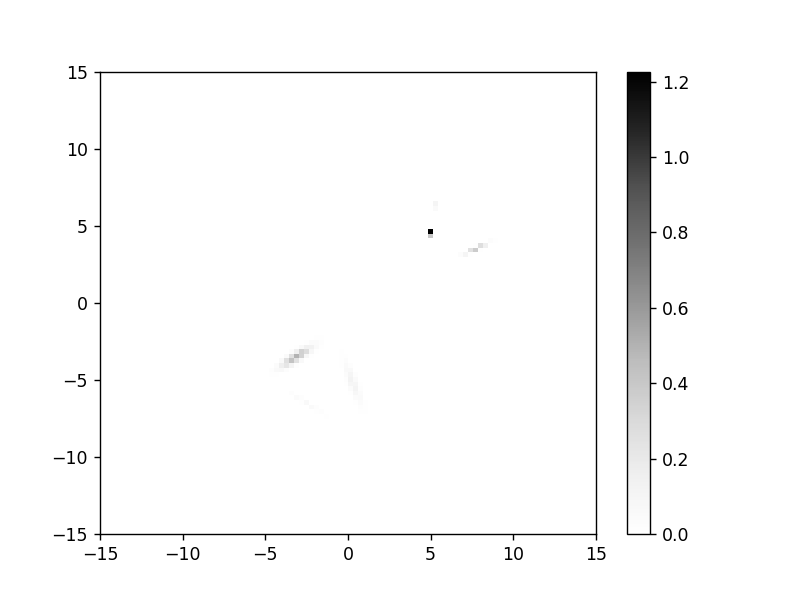

In [551]:
if(d==2):
    X,Y = np.meshgrid(np.linspace(1.5*xmin,1.5*xmax,100),np.linspace(1.5*xmin,1.5*xmax,100),indexing="ij")
    pos = np.dstack((X,Y))
    cum_distrib = np.zeros_like(X)
    for k in range(K):
        rd = multivariate_normal(mean=mu_k[k,:],cov=cov_mat[k,...])
        add = rd.pdf(pos)
        cum_distrib+=pi_k[k]*add
    plt.figure()
    plt.imshow(cum_distrib,cmap="Greys",aspect="auto",origin="lower",extent=[X.min(),X.max(),Y.min(),Y.max()])
    plt.colorbar()
if(d==1):
    X=np.linspace(1.5*xmin,1.5*xmax,100)
    
    cum_distrib = np.zeros_like(X)
    for k in range(K):
        rd = multivariate_normal(mean=mu_k[k,:],cov=cov_mat[k,...])
        add = pi_k[k]* rd.pdf(X)
        cum_distrib+=add
    plt.figure()
    plt.plot(X,cum_distrib/np.sum(cum_distrib))

# Construct data samples


z = np.random.rand(N)
Z = np.zeros((K,N))
for i in range(N):
    index = np.where(z[i]>cum_sum_pi_k)[0][-1]
    Z[index,i] = 1
    
X = np.zeros((d,N))
all_data_samples = []
for k in range(K):
    all_data_samples.append(multivariate_normal.rvs(mean = mu_k[k,:], cov = cov_mat[k,:,:], size=N).T)
all_data_samples = np.stack(all_data_samples)
for k in range(K):
    X+= all_data_samples[k,:,:]*Z[k,:]
del all_data_samples

In [552]:
z = np.random.rand(N)
Z = np.zeros((K,N))
for i in range(N): 
    index = np.where(z[i]>cum_sum_pi_k)[0][-1]
    Z[index,i] = 1

X = np.zeros((d,N)) 
all_data_samples = [] 
for k in range(K):
    all_data_samples.append(multivariate_normal.rvs(mean = mu_k[k,:], cov = cov_mat[k,:,:], size=N).T) 
all_data_samples = np.stack(all_data_samples) 
if(d !=1):
    for k in range(K): 
        X+= all_data_samples[k,:,:]*Z[k,:]
else:
    for k in range(K): 
        X+= all_data_samples[k,:]*Z[k,:]
del all_data_samples
del Z


# Visualize samples

<IPython.core.display.Javascript object>


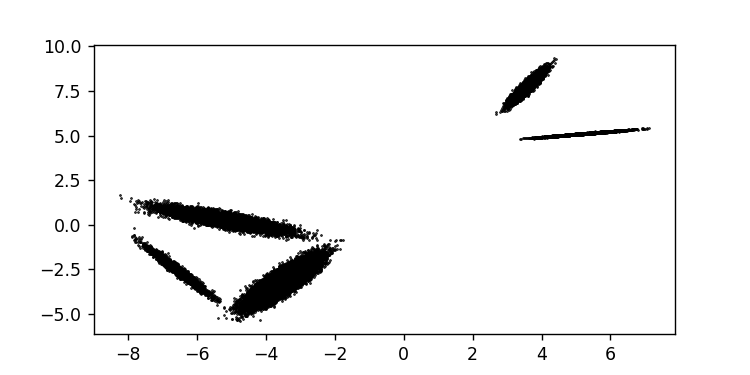

In [553]:
plt.figure(figsize=(6,3))
if(d==2):
    plt.plot(X[0,:],X[1,:],"k.",markersize = 1)
if(d==1):
    hh,h = np.histogram(X[0,:],bins=200,density=1)
    plt.plot(h[0:-1],hh)

# Implement EM algorithm
Known data: X,K
Result: pi_k, mu_k, cov_k

In [580]:
#initialize estimates
xmax_estimate = 10.
xmin=-xmax
estimate_mu_k = xmax*2*(np.random.rand(K*d).reshape((K,d))-0.5)
estimate_mu_k *=0
estimate_cov_mat = np.zeros((K,d,d))
for k in range(K):
    rd_matrix = np.random.randn(d,d)
    rd_matrix = rd_matrix.T@rd_matrix
    estimate_cov_mat[k,:,:] = np.eye(2)
    del rd_matrix
estimate_pi_k = np.random.rand(K)
estimate_pi_k/=np.sum(estimate_pi_k)


In [581]:
def compute_E_step(XT,mu,cov,pi):
    global K,N
    gamma = np.zeros((K,N))
    for k in range(K):
        gamma[k,:] = pi[k]*multivariate_normal.pdf(XT,mean=mu[k,:],cov=cov[k,:,:])
    gamma/=np.sum(gamma,axis=0)
    return gamma

In [582]:
def compute_M_step(X,gamma):
    global K,N
    mu_new = np.zeros((K,d))
    cov_new = np.zeros((K,d,d))
    pi_new = np.zeros(K)
    Nk = np.sum(gamma,axis=1)
    pi_new = Nk/N
    XT=X.T
    for k in range(K):
        mu_new[k,:] = np.sum(X*gamma[k,:],axis=1)/Nk[k]
        x_m_mu = (XT-mu_new[k,:])
        cov_new[k,:,:] = 1e-9+(gamma[k,:]*x_m_mu.T)@(x_m_mu)*(1./Nk[k])

    return pi_new,mu_new,cov_new

# def compute_M_step(X,gamma):
#     mu_new = np.zeros((K,d))
#     cov_new = np.zeros((K,d,d))
#     pi_new = np.zeros(K)
#     Nk = np.sum(gamma,axis=1)
#     pi_new = Nk/N
#     for k in range(K):
#         mu_new[k,:] = np.sum(X*gamma[k,:])/(Nk[k])
#         xx= X[0,:]
#         cc = 1/Nk[k]*np.sum(gamma[k,:]*(xx-mu_new[k,:])**2)
#         cov_new[k,0,0] = cc+1e-9
#     return pi_new,mu_new,cov_new


def compute_log_likelihood(XT,mu,cov,pi):
 
    LL = np.zeros((K,N))
    for k in range(K):
        LL[k,:] = (pi[k]*multivariate_normal.pdf(XT,mean=mu[k,:],cov=cov[k,...]))
    LL = np.sum(np.log(np.sum(LL,axis=0)))
    return LL

In [ ]:
num_it=100
LL = np.zeros(num_it)
XT=X.T
for ite in tqdm(range(num_it)):
    gamma = compute_E_step(XT, estimate_mu_k, estimate_cov_mat, estimate_pi_k)
    pi_new,mu_new,cov_new = compute_M_step(X,gamma)
    estimate_cov_mat =1* cov_new
    estimate_mu_k =1* mu_new
    estimate_pi_k =1* pi_new
    LL[ite] = compute_log_likelihood(XT,estimate_mu_k, estimate_cov_mat, estimate_pi_k)


In [ ]:
plt.figure()
plt.plot(LL)